In [18]:
import pandas as pd
import os
import socceraction.spadl as spadl
from socceraction.vaep.formula import value
import numpy as np

home = "/home/pastor/projects/FriendsOfTracking/FOT/data/"

# read all csv files in the folder and append in a single dataframe
def read_all_csv_files(folder):
    df = pd.DataFrame()
    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            df = pd.concat([df, pd.read_csv(os.path.join(folder, filename))])
    
    df.drop_duplicates(subset='game_id', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def get_features_labels(games):
    dfs_features = []
    dfs_labels = []
    for row in games.itertuples():
        game_id = row.game_id
        #print(f'Processing game {game_id}')
        
        try:
            df_features = pd.read_hdf(home + 'features.h5', key=f'game_{game_id}')
        except KeyError:
            print(f'Error reading features for game {game_id}')
            continue

        df_features['game_id'] = game_id
        dfs_features.append(df_features)

        df_labels = pd.read_hdf(home + 'labels.h5', key=f'game_{game_id}')
        df_labels['game_id'] = game_id
        dfs_labels.append(df_labels)
        
    df_labels = pd.concat(dfs_labels).reset_index(drop=True)
    df_features = pd.concat(dfs_features).reset_index(drop=True)

    return df_features, df_labels

def get_actions(games):
    
    dfs_actions = []
    for row in games.itertuples(): #zip(last_games['game_id'].values, last_games['home_team_id'].values):
        
        game_id = row.game_id
        #print(f'Processing game {game_id}')
        
        try:
            df_actions = pd.read_hdf(home + 'actions.h5', key=f'game_{game_id}')
        except KeyError:
            print(f'Error reading actions for game {game_id}')
            continue
        team_name = pd.read_hdf(home + 'teams.h5', key=f'game_{game_id}')
        player_name = pd.read_hdf(home + 'players.h5', key=f'game_{game_id}')
        df_actions = (spadl
            #df_actions#spadl
            .add_names(df_actions)  # add actiontype and result names
            .merge(team_name, how='left')  # add team names
            .merge(player_name, how='left')  # add player names
            #.sort_values(["game_id", "period_id", "action_id"])
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )
        dfs_actions.append(df_actions)
    df_actions = pd.concat(dfs_actions).reset_index(drop=True)

    return df_actions

In [2]:
df = read_all_csv_files(home)

In [3]:
df_train = df[df['season_id'] != 188989]

In [4]:
df_test = df[df['season_id'] == 188989]

In [5]:
df_features, df_labels = get_features_labels(df_train)
df_actions = get_actions(df_train)

In [6]:
df_features_test, df_labels_test = get_features_labels(df_test)
df_actions_test = get_actions(df_test)

# Training

In [7]:
from xgboost import XGBClassifier

In [8]:
# find a better validation technique
features = [
    'start_dist_to_goal_a0',
    'end_dist_to_goal_a0',
    'start_dist_to_goal_a1',
    'end_dist_to_goal_a1',
    'start_dist_to_goal_a2',
    'end_dist_to_goal_a2',
    'start_angle_to_goal_a0',
    'end_angle_to_goal_a0',
    'start_angle_to_goal_a1',
    'end_angle_to_goal_a1',
    'start_angle_to_goal_a2',
    'end_angle_to_goal_a2',
    'team_1',
    'team_2'
]
labels = ['scores',
          'concedes'
          ]

In [9]:
def train_model(features_data, label_data):
    
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=3
    )
    model.fit(
        X=features_data,
        y=label_data
    )
    return model


In [10]:
def prediction(model, features_data):
    probabilities = model.predict_proba(
        features_data
    )
    predictions = probabilities[:, 1]
    return predictions

In [14]:
dfs_predictions = {}
models = {}
for label in labels:
    model = train_model(df_features[features], df_labels[label])
    models[label] = model
    #predictions = prediction(model, df_features[features])
    #dfs_predictions[label] = pd.Series(predictions, index=df_features.index)

#df_predictions = pd.concat(dfs_predictions, axis=1)

In [15]:
dfs_predictions_test = {}
for label in labels:
    predictions_test = prediction(models[label], df_features_test[features])
    dfs_predictions_test[label] = pd.Series(predictions_test, index=df_features_test.index)

df_predictions_test = pd.concat(dfs_predictions_test, axis=1)

<Axes: ylabel='Frequency'>

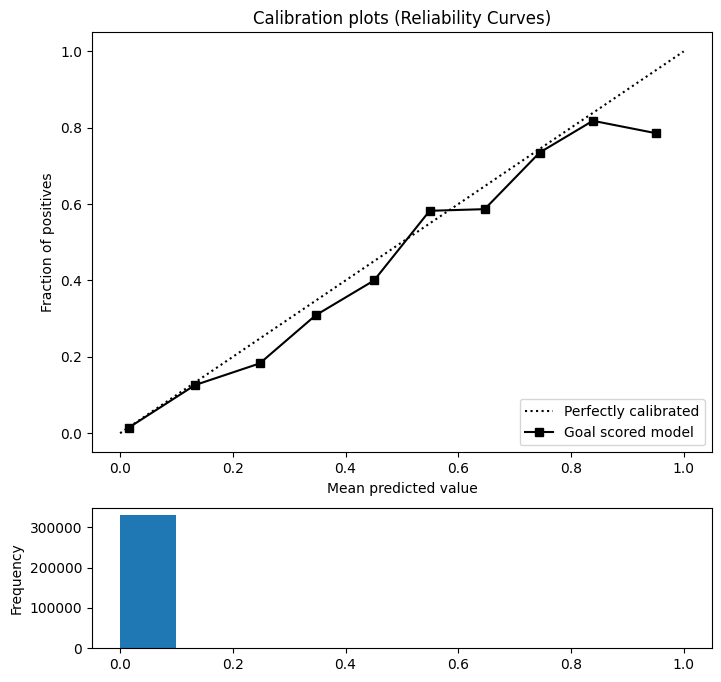

In [20]:
from scikitplot.metrics import plot_calibration_curve
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={'height_ratios':[3, 1]
    }
)
plot_calibration_curve(
    y_true=df_labels_test['scores'],
    probas_list=[df_predictions_test['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)

df_predictions_test['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2
)

In [21]:
df_actions_predictions_test = pd.concat([df_actions_test, df_predictions_test], axis=1)

# Rank system

In [22]:
def rank_actions(df_actions_predictions):
    dfs_values = []
    for _, game_predictions in df_actions_predictions.groupby('game_id'):
        df_values = value(game_predictions, game_predictions['scores'], game_predictions['concedes'])
        
        df_all = pd.concat([game_predictions, df_values], axis=1)
        dfs_values.append(df_all)

    df_values = (pd.concat(dfs_values)
        .sort_values(['game_id', 'period_id', 'time_seconds'])
        .reset_index(drop=True)
    )

    df_ranking = (df_values[['player_id', 'team_name', 'nickname', 'vaep_value']]
        .groupby(['player_id', 'team_name', 'nickname'])
        .agg(vaep_count=('vaep_value', 'count'), 
            vaep_mean=('vaep_value', 'mean'),
            vaep_sum=('vaep_value', 'sum'))
        .sort_values('vaep_sum', ascending=False)
        .reset_index()
    )
    return df_ranking

In [24]:
df_ranking = rank_actions(df_actions_predictions_test)

In [25]:
df_player_games = []
for row in df_test.itertuples():
    game_id = row.game_id
    game_player = pd.read_hdf(home + 'players.h5', key=f'game_{game_id}')
    df_player_games.append(game_player)

df_player_games = pd.concat(df_player_games).reset_index(drop=True)
df_minutes_played = df_player_games.groupby(['player_id'])['minutes_played'].sum().reset_index()
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

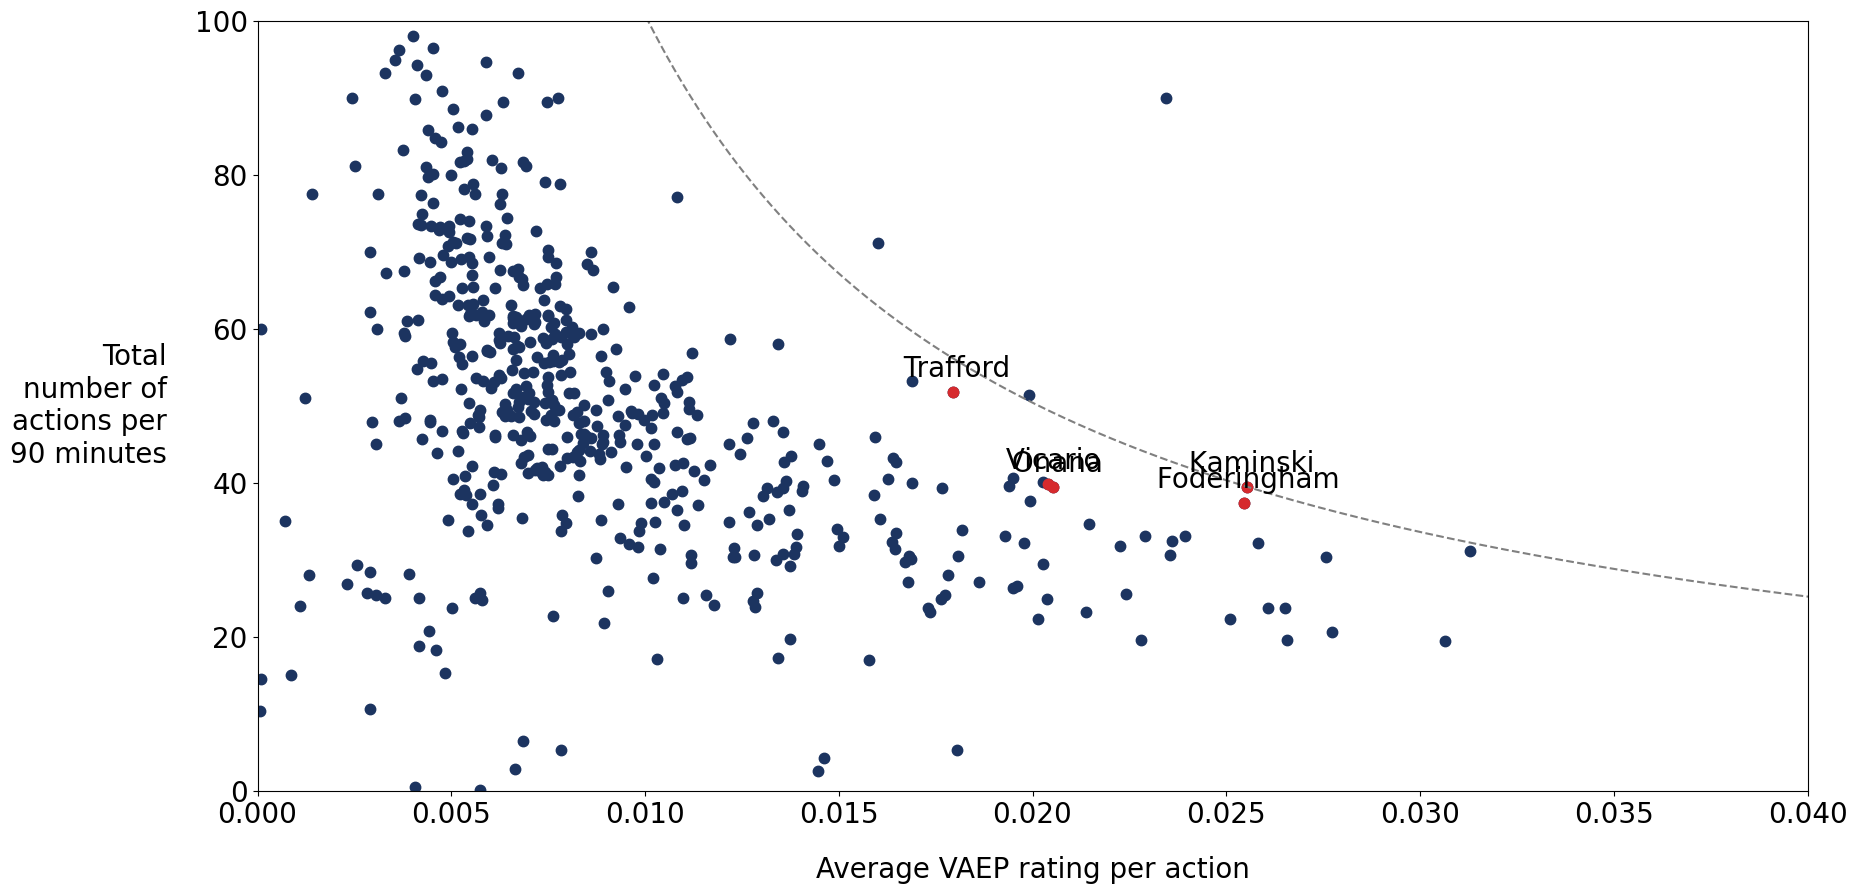

In [26]:
plt.figure(figsize=(20, 10))
x = list(df_ranking_p90['vaep_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_ranking_p90['vaep_mean'][0:5])
y_best = list(df_ranking_p90['actions_p90'][0:5])
names = list(df_ranking_p90['nickname'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')

best_player = x[0] * y[0]
yi = np.arange(0.1, 100, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.04)
plt.ylim(0, 100)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()